# CRPS Verifications

In [1]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import verif_utils as vu
import graph_utils as gu

In [3]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [10]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
from scipy.stats import wilcoxon

def wilcoxon_by_leads(FCST1, FCST2):
    L, N_boot = FCST1.shape
    w_stat = np.empty((L,))
    p_vals = np.empty((L,))
    
    series1 = FCST1
    series2 = FCST2
    
    for i in range(L):
        w_, p_ = wilcoxon(series1[i, :], series2[i, :],)
        w_stat[i] = w_
        p_vals[i] = p_
    return w_stat, p_vals

In [6]:
# with h5py.File(save_dir+'CCPA_domain.hdf', 'r') as h5io:
#     lon_CCPA = h5io['lon_CCPA'][...]
#     lat_CCPA = h5io['lat_CCPA'][...]
#     land_mask_CCPA = h5io['land_mask_CCPA'][...]
# land_mask_ = land_mask_CCPA==1
# grid_shape = land_mask_.shape

In [7]:
LEADs = np.arange(6, 144+6, 6)
N_leads = len(LEADs)
CRPS = np.load(result_dir+'CRPSS_Bootstrap.npy', allow_pickle=True)[()]
ref = CRPS['ref']

In [8]:
colors_sub = np.array([[248, 206, 204], [218, 232, 252], [232, 232, 232]])/255
colors_main = [red, blue, cyan]
gray_main = np.array([102, 102, 102])/255
gray_sub = np.array([245, 245, 245])/255

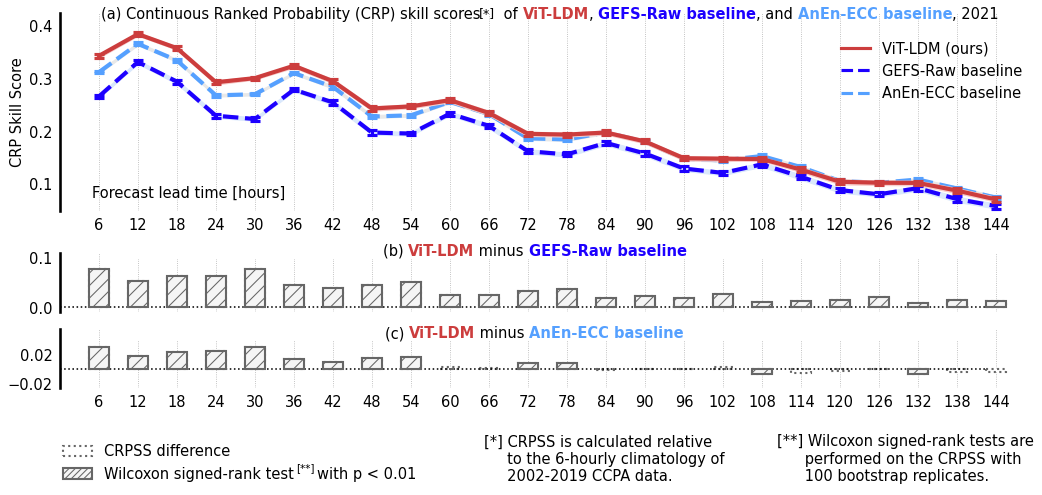

In [11]:
keys = ['LDM', 'RAW', 'AnEn']

linestyles = ['-', '--', '--']
zorders_fill = [5, 4, 3]
zorders_line = [6, 5, 4]
zorder_word = 7


fig = plt.figure(figsize=(13, 5), dpi=dpi_)
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.05, 0.3, 0.3])#, width_ratios=[1, 0.1, 1, 0.1, 1])

handles = []

ax_main = plt.subplot(gs[0, 0])
ax_gap = plt.subplot(gs[1, 0])
ax_diff1 = plt.subplot(gs[2, 0])
ax_diff2 = plt.subplot(gs[3, 0])

AX_diff = [ax_diff1, ax_diff2]

plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.0)
ax_gap.set_axis_off()

bar_w = 0.309 #0.618
keys = ['LDM', 'RAW', 'AnEn']
labels = ['ViT-LDM (ours)', 'GEFS-Raw baseline', 'AnEn-ECC baseline', ]

for t, key in enumerate(keys):
    
    CRPS_mean = np.mean(CRPS[key], axis=1)
    CRPSS_mean = 1 - CRPS_mean/ref
    CRPS_bootstrap = 1 - CRPS[key]/ref[:, None]

    if key == 'LDM':
        CRPSS_LDM = CRPSS_mean
        CRPSS_LDM_bootstrap = CRPS_bootstrap
        
    temp_99 = np.quantile(CRPS_bootstrap, 0.95, axis=1)
    temp_01 = np.quantile(CRPS_bootstrap, 0.05, axis=1)
    error = 0.5*(temp_99 - temp_01)
    
    ax_main.fill_between(LEADs, temp_01, temp_99, interpolate=True, 
                         color=colors_sub[t], zorder=zorders_fill[t])
    
    (_, caps, _) = ax_main.errorbar(LEADs, CRPSS_mean, yerr=error, linestyle=linestyles[t], capsize=5, 
                                    color=colors_main[t], linewidth=4.0, elinewidth=3.0, zorder=zorders_line[t])
    for cap in caps:
        cap.set_markeredgewidth(3)
        
    if t > 0:
        diff_ = CRPSS_LDM-CRPSS_mean
        AX_diff[t-1].bar(LEADs, diff_, bottom=0.0, color='w', edgecolor=gray_main, 
                         linestyle=':', linewidth=2.0, width=5*0.618, zorder=2)
        
        # _, p_vals = wilcoxon_by_leads(CRPSS_LDM_bootstrap, CRPS_bootstrap)
        # diff_[p_vals >= 0.01] = np.nan
        
        if t == 1:
            diff_[np.abs(diff_)<0.005] = np.nan
        else:
            diff_[np.abs(diff_)<0.005] = np.nan
            
        AX_diff[t-1].bar(LEADs, diff_, bottom=0.0, color=gray_sub, edgecolor=gray_main, 
                         linewidth=2.0, hatch='//', width=5*0.618, zorder=3)
        
ax_main = gu.ax_decorate(ax_main, left_flag=True, bottom_flag=True, bottom_spline=False)
ax_diff1 = gu.ax_decorate(ax_diff1, left_flag=True, bottom_flag=False, bottom_spline=False)
ax_diff2 = gu.ax_decorate(ax_diff2, left_flag=True, bottom_flag=True, bottom_spline=False)

AX = [ax_main, ax_diff1, ax_diff2]

for ax in AX:
    ax.yaxis.grid(False)
    ax.grid(':', axis='x')
    ax.set_xlim([0, 150])
    ax.set_xticks(LEADs)
    
ax_main.set_ylim([0.05, 0.425])
ax_main.set_yticks([0.1, 0.2, 0.3, 0.4])
ax_main.set_ylabel('CRP Skill Score', fontsize=14)

ax_diff1.set_ylim([-0.01, 0.11])
ax_diff2.set_ylim([-0.025, 0.055])
ax_diff2.set_yticks([-0.02, 0.02])

ax_diff1.axhline(y=0, xmin=0, xmax=0.95, linestyle=':', linewidth=1.5, color='k')
ax_diff2.axhline(y=0, xmin=0, xmax=0.95, linestyle=':', linewidth=1.5, color='k')
#
    
AX = [ax_main, ax_diff2]
locy = [0.1, 0.1]

for i, ax in enumerate(AX):
    ax.yaxis.grid(False)
    ax.grid(':', axis='x')
    ax.set_xticks(LEADs)
    # ax.set_xticklabels(['00', '01-05Z', '02-06Z', '03-07Z', 
    #                     '04-08Z', '05-09Z', '06-10Z', '07-11Z',
    #                     '08-12Z', '09-13Z', '10-14Z', '11-15Z',
    #                     '12-16Z', '13-17Z', '14-18Z', '15-19Z',
    #                     '16-20Z', '17-21Z', '18-22Z', '19-23Z', '20-00Z'], y=locy[i], rotation=30)


ax_title1 = fig.add_axes([0.0, 0.975, 1.0, 0.04])
title_len = 0.915
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal', 'bold', 'normal']
handles += gu.string_partial_format(fig, ax_title1, 0.5*(1-title_len), 1.0, 'left', 'top', 
                                    ['(a) Continuous Ranked Probability (CRP) skill scores     of ',
                                     'ViT-LDM', ', ', 'GEFS-Raw baseline', ', and ', 'AnEn-ECC baseline', ', 2021'], 
                                    ['k', colors_main[0], 'k', colors_main[1], 'k', colors_main[2], 'k'], 
                                    fontsize_list, fontweight_list)
ax_title1.text(0.43, 1.0, '[*]', va='top', fontsize=12, transform=ax_title1.transAxes)


ax_title2 = fig.add_axes([0.05, 0.345, 0.9, 0.04])
title_len = 0.375
ax_title2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                      labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_title2.set_facecolor('w')
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold']
handles += gu.string_partial_format(fig, ax_title2, 0.5*(1-title_len), 1.0, 'left', 'top', 
                                    ['(b) ', 'ViT-LDM', ' minus ', 'GEFS-Raw baseline'], 
                                    ['k', colors_main[0], 'k', colors_main[1]], fontsize_list, fontweight_list)

ax_title3 = fig.add_axes([0.05, 0.125, 0.9, 0.04])
title_len = 0.37
ax_title3.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                      labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_title3.set_facecolor('w')
fontsize_list = [14,]*10
fontweight_list = ['normal', 'bold', 'normal', 'bold']
handles += gu.string_partial_format(fig, ax_title3, 0.5*(1-title_len), 1.0, 'left', 'top', 
                                    ['(c) ', 'ViT-LDM', ' minus ', 'AnEn-ECC baseline'], 
                                    ['k', colors_main[0], 'k', colors_main[2]], fontsize_list, fontweight_list)
handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], linestyle='-', color=colors_main[0], linewidth=3.0, label=''))
handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[1], linewidth=3.0, label=''))
handle_legneds1.append(mlines.Line2D([], [], linestyle='--', color=colors_main[2], linewidth=3.0, label=''))

ax_lg1 = fig.add_axes([0.8, 0.75, 0.2, 0.175*6/5])
LG1 = ax_lg1.legend(handle_legneds1, labels, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})
gu.legend_format(LG1)

handle_legneds2 = []
handle_legneds2.append(patches.Patch(facecolor='none', edgecolor=gray_main, linewidth=2.0, linestyle=':', label='CRPSS difference'))
handle_legneds2.append(patches.Patch(facecolor=gray_sub, edgecolor=gray_main, linewidth=2.0, 
                                     hatch='////', label='Wilcoxon signed-rank test     with p < 0.01'))

ax_lg2 = fig.add_axes([-0.01, -0.25, 0.4, 0.1])
LG2 = ax_lg2.legend(handles=handle_legneds2, bbox_to_anchor=(0.0, 0.5), ncol=1, loc=6, 
                    prop={'size':14}, fancybox=False);
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)

ax_lg2.text(0.63, 0.5, '[**]', va='top', fontsize=10, transform=ax_lg2.transAxes)

ax_w1 = fig.add_axes([0.435, -0.25, 0.245, 0.1*6/5])
ax_w1.text(0, 0.5, '[*] CRPSS is calculated relative\n     to the 6-hourly climatology of\n     2002-2019 CCPA data.', 
          ha='left', va='center', fontsize=14, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([0.735, -0.25, 0.265, 0.1*6/5])

ax_w2.text(0, 0.5, '[**] Wilcoxon signed-rank tests are\n      performed on the CRPSS with\n      100 bootstrap replicates.', 
          ha='left', va='center', fontsize=14, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([0.0325, 0.5, 0.2, 0.04])
ax_w3.text(0, 0.5, 'Forecast lead time [hours]', 
          ha='left', va='center', fontsize=14, transform=ax_w3.transAxes);

ax_title1.set_axis_off()
[j.set_linewidth(0.0) for j in ax_title2.spines.values()]
[j.set_linewidth(0.0) for j in ax_title3.spines.values()]
ax_lg1.set_axis_off()
ax_lg2.set_axis_off()
ax_w1.set_axis_off()
ax_w2.set_axis_off()
ax_w3.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig7_crpss.png', format='png', **fig_keys)